# Analiza sentymentu z wykorzystaniem BERT i zbioru Amazon Reviews

## Przygotowanie środowiska

In [ ]:
!pip install -qq transformers
!pip install wget
!pip install --upgrade imbalanced-learn
!pip install pyenchant
!apt-get install -y libenchant-dev
!pip install spacy
!python -m spacy download en_core_web_sm

Inicjalizacja stałych:

In [1]:
import os
BERT_URL = "https://github.com/parvex/BERT-sentiment-analasysis/raw/BIG-BRANCH-WITH-BERT-USE-CAREFULLY/predict_review/model/model.pt"
BERT_path = os.path.join("model", "model.pt")
DATASET_URL = "https://github.com/parvex/BERT-sentiment-analasysis/raw/BIG-BRANCH-WITH-BERT-USE-CAREFULLY/data/dataset.csv"
DATASET_PATH = os.path.join("data", "dataset.csv")
class_names = ['1', '2', '3', '4', '5']
RANDOM_SEED = 1232
TOKEN_MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 2
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Importowanie bibliotek:

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import collections
import transformers
import pandas as pd
import gzip
import wget
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score, recall_score, auc
from sklearn.preprocessing import label_binarize
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import requests
from imblearn.under_sampling import RandomUnderSampler
import torch.nn.functional as F
from google.colab import drive
from shutil import copyfile
import re
from tqdm import tqdm
from difflib import SequenceMatcher
import nltk as nltk
from enchant.checker import SpellChecker
from transformers import BertForMaskedLM, BertTokenizer
import spacy

# Uncomment if you want to save the model on Google Drive after the training
#drive.mount('/content/drive', force_remount=True)

util.py:

In [ ]:
def check_file_status(filepath, filesize):
  sys.stdout.write('\r')
  sys.stdout.flush()
  size = int(os.stat(filepath).st_size)
  percent_complete = (size/filesize)*100
  sys.stdout.write('%.3f %s' % (percent_complete, '% Completed'))
  sys.stdout.flush()


def download_file(file_url: str, target_path: str):
  os.makedirs(os.path.dirname(target_path), exist_ok=True)
  req = requests.get(file_url, stream=True)
  filesize = int(req.headers['Content-length'])
  with open(target_path, 'wb') as outfile:
    chunk_size = 1048576
    for chunk in req.iter_content(chunk_size=chunk_size):
      outfile.write(chunk)
      if chunk_size < filesize:
        check_file_status(target_path, filesize)
    check_file_status(target_path, filesize)
    print()


def download_bert():
  print('Downloading BERT...')
  download_file(BERT_URL, BERT_path)


def download_dataset():
  print('Downloading dataset...')
  download_file(DATASET_URL, DATASET_PATH)

Pobieranie zbioru danych i rozpakowywanie:

In [5]:
if not os.path.exists(DATASET_PATH):
  download_dataset()
df = pd.read_csv("./data/dataset.csv")

## Analiza danych:

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [8]:
df.shape

(551682, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      551682 non-null  object 
 1   asin            551682 non-null  object 
 2   reviewerName    546729 non-null  object 
 3   helpful         551682 non-null  object 
 4   reviewText      551682 non-null  object 
 5   overall         551682 non-null  float64
 6   summary         551682 non-null  object 
 7   unixReviewTime  551682 non-null  int64  
 8   reviewTime      551682 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.1+ MB


Histogram ilości słów w opinii:

Text(0.5, 0, 'review score')

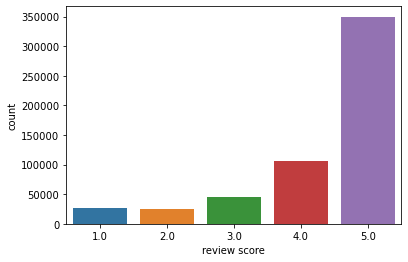

In [10]:
sns.countplot(x='overall', data=df)
plt.xlabel('review score')

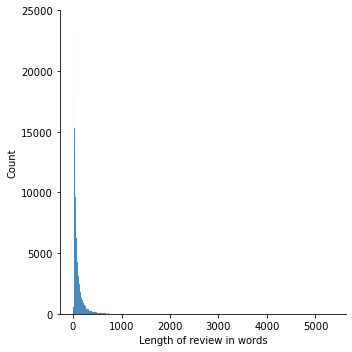

In [11]:
numbers_of_words = df['reviewText'].str.split().str.len()
plot = sns.displot(numbers_of_words, )
plot.set_axis_labels('Length of review in words', 'Count')

Jak widać zbiór jest mocno niezbalansowany, więc istnieje konieczność jego zbalansowania. Ze względu na tekstowy charakter zbioru zastosowanie generującego upsamplingu odpada, iilość danych w zbiorze jest duża, więc undersampling będzie odpowiednim rozwiązaniem.

Przeważająca większość opinii jest krótsza niż 512 słów.

### Definicja klasy ReviewDataset potrzebnej do przeprowadzenia treningu:

In [ ]:
class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt'
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### Definicja modelu SentimentClassifier:

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, pretrained_model_name):
    super().__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

### Definicja pomocniczych metod:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.reviewText.to_numpy(),
    targets=df.overall.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, losses

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


def get_predictions(model, data_loader, device):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

## Przygotowanie zbiorów treningowego i testowego:

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
df['overall'] -= 1
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_SEED, stratify=df[['overall']])
print('df_train: ' + str(len(df_train)))
print('df test: ' + str(len(df_test)))

NameError: name 'BertTokenizer' is not defined

Podział klas zbioru treningowego:

In [ ]:
sns.countplot(x='overall',data=df_train)
plt.xlabel('review score')

Jak wynika z analizy, większość słów mieści się w zakresie 0-256 słów, więc ustalenie limitu tokenów BERT na górny próg - 256 będzie wystarczające. Dłuższe opinie zostaną skrócone do długości 256 tokenów.

### Przygotowanie do treningu:

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_loader = create_data_loader(df_train, tokenizer, TOKEN_MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, TOKEN_MAX_LEN, BATCH_SIZE)

model = SentimentClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#class weights for loss function for imbalanced problem
class_weights = compute_class_weight(classes=[0,1,2,3,4], y=df_train['overall'], class_weight='balanced')
class_weights = torch.FloatTensor(class_weights).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

### Trening:

In [3]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

# Uncomment to save model to Google Drive:
# os.makedirs("model", exist_ok=True)
# torch.save(model.state_dict(), "model/model.pt")
# os.makedirs('/content/drive/My Drive/BERT', exist_ok = True)
# copyfile('model/model.pt', '/content/drive/My Drive/BERT/model.pt')
# drive.flush_and_unmount()

NameError: name 'defaultdict' is not defined

## Wyniki treningu

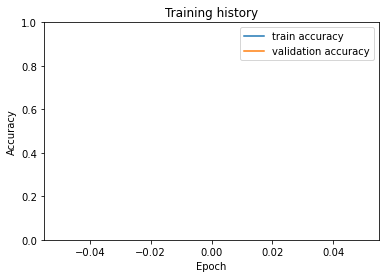

In [16]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Ewaluacja na zbiorze testowym:

In [17]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 6.00 GiB total capacity; 4.32 GiB already allocated; 21.16 MiB free; 4.37 GiB reserved in total by PyTorch)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader,
  device
)

Macierz pomyłek oraz średni moduł błędu:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
torch.mean(torch.abs(y_test - y_pred) * 1.0)

### Metryki:

In [ ]:
y_test_vec = label_binarize(y_test, classes=[0,1,2,3,4])
precision, recall, _ = precision_recall_curve(y_test_vec.ravel(), y_pred_probs.ravel())
average_precision = average_precision_score(y_test_vec, y_pred_probs, average="micro")
average_recall = recall_score(y_test, y_pred, average="micro")
f1_score = 2*average_precision*average_recall/(average_precision+average_recall)
pr_auc = auc(recall, precision)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
  'Average precision, recall, area under curve, f1 score, micro-averaged over all classes: AP={0:0.2f}, AR={1:0.2f}, AUC={2:0.2f}, F1={3:0.2f}'
    .format(average_precision, average_recall, pr_auc, f1_score))

## Sprawdzenie pojedynczej opinii

Musimy najpierw podać definicję klasy Preprocessing przeprowadzającej wstępne przetwarzanie opinii:

In [ ]:
rep = {'\n': ' ', '\\': ' ', '/': '', '-': ' ',
       '"': ' " ', ',': ' , ', '.': ' . ', '!': ' ! ',
       '?': ' ? ', "n't": " not", "'ll": " will", '*': ' * ',
       '(': ' ( ', ')': ' ) ', "s'": "s '"}
rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys()))
nltk.download('punkt')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')


class Preprocessing:

  def __init__(self) -> None:
    super().__init__()
    self.nlp = spacy.load("en")

  def preprocess_text(self, original_text: str):
    if original_text == '':
      return ""
    original_text = " ".join(str(original_text).split()[:TOKEN_MAX_LEN])
    # remove http links and numbers
    processed_text = re.sub(r'(https?://(www\.)?[^\s]+)|\d+', "", original_text)
    processed_text = pattern.sub(lambda m: rep[re.escape(m.group(0))], processed_text)
    named_entities = Preprocessing.get_named_entities_list(processed_text)
    for name in named_entities:
      processed_text.replace(name, "")

    incorrect_words, suggested_words = self.identify_incorrect_words(processed_text)
    if len(incorrect_words) == 0:
      processed_text = self._predict_words(processed_text, incorrect_words, suggested_words)

    doc = self.nlp(processed_text)
    text = " ".join([token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in doc])
    return text

  def _predict_words(self, text, incorrect_words, spell_checker_suggestions):
    for i, word in enumerate(incorrect_words):
      if len(spell_checker_suggestions[i]) > 0:
        text = text.replace(word, spell_checker_suggestions[i][0], 1)
    return text

  @staticmethod
  def identify_incorrect_words(text):
    ignorewords = ["!", ",", ".", "\"", "?", '(', ')', '*', '\'']
    spell_checker = SpellChecker("en_US")
    words = text.split()
    # get incorrect words
    incorrect_words = [w for w in words if not spell_checker.check(w) and w not in ignorewords]
    suggested_words = [spell_checker.suggest(word) for word in incorrect_words]
    return incorrect_words, suggested_words

  @staticmethod
  def get_named_entities_list(text: str):
    chunked = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
      if type(i) == nltk.Tree:
        current_chunk.append(" ".join([token for token, pos in i.leaves()]))
      if current_chunk:
        named_entity = " ".join(current_chunk)
        if named_entity not in continuous_chunk:
          continuous_chunk.append(named_entity)
          current_chunk = []
      else:
        continue
    return continuous_chunk

In [ ]:
review_text = """I like it, perfect"""
preprocessing = Preprocessing()
preprocessed_text = preprocessing.preprocess_text(review_text)
encoded_review = tokenizer.encode_plus(
  preprocessed_text,
  max_length=TOKEN_MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  verbose=False
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Processed review text: {preprocessed_text}')
print(f'Sentiment  : {class_names[prediction]}')

## Dziękujemy :)